# EDA 

**Table of content**

* [Data overveiw](#overview)
* [Analyze alarms data](#alarms)
    * [Alarms distribution in time](#alarms_in_time)
    * [Alarms distribution by regions](#alarms_in_regions)
    * [Alarms distribution by duration](#alarms_durations)
* [Analyze weather data](#weather)
* [Analyze ISW reports](#reports)
    * [The time interval that the data cover](#reports_time)
    * [N-grams analyzis](#reports_n_grams)
    * [Idf_weights](#reports_idf)

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
import pathlib

from IPython.display import display
from collections import Counter

import nltk
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from text_preprocessing import *

[nltk_data] Downloading package punkt to /home/vlad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data_folder = os.path.join(pathlib.Path().resolve(), 'data/data_before_lab_3')
alarms_path = os.path.join(data_folder, 'alarms.csv')
all_weather_by_hour_path = os.path.join(data_folder, 'all_weather_by_hour.csv')
regions_path = os.path.join(data_folder, 'regions.csv')
reports_path = os.path.join(data_folder, 'reports_processed.csv')

In [3]:
alarms = pd.read_csv(alarms_path, sep=';')
all_weather_by_hour = pd.read_csv(all_weather_by_hour_path)
regions = pd.read_csv(regions_path)
reports = pd.read_csv(reports_path, sep=';')

## Data overview <a class="anchor" id="overview"></a>

In [4]:
display(regions.head())
display(regions.shape)
display(alarms.head())
display(alarms.shape)
display(all_weather_by_hour.head())
display(all_weather_by_hour.shape)
display(all_weather_by_hour.columns)
display(reports.head())
display(reports.shape)

,region,center_city_ua,center_city_en,region_alt,region_id
0,АР Крим,Сімферополь,Simferopol,Крим,1
1,Вінницька,Вінниця,Vinnytsia,Вінниччина,2
2,Волинська,Луцьк,Lutsk,Волинь,3
3,Дніпропетровська,Дніпро,Dnipro,Дніпропетровщина,4
4,Донецька,Донецьк,Donetsk,Донеччина,5


(25, 5)

,id,region_id,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id
0,2,3,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN
1,4,12,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN
2,5,14,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN
3,6,6,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN
4,7,3,Вінниччина,Вінниця,0,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 10:42:41,NaN


(19933, 9)

,city_latitude,city_longitude,city_resolvedAddress,city_address,city_timezone,city_tzoffset,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,...,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,hour_icon,hour_source,hour_stations
0,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,89.0,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote
1,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,71.1,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote
2,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,95.4,0.0,NaN,0.0,10.0,Overcast,cloudy,obs,remote
3,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,74.6,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote
4,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,67.8,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote


(190656, 67)

Index(['city_latitude', 'city_longitude', 'city_resolvedAddress',
       'city_address', 'city_timezone', 'city_tzoffset', 'day_datetime',
       'day_datetimeEpoch', 'day_tempmax', 'day_tempmin', 'day_temp',
       'day_feelslikemax', 'day_feelslikemin', 'day_feelslike', 'day_dew',
       'day_humidity', 'day_precip', 'day_precipprob', 'day_precipcover',
       'day_snow', 'day_snowdepth', 'day_windgust', 'day_windspeed',
       'day_winddir', 'day_pressure', 'day_cloudcover', 'day_visibility',
       'day_solarradiation', 'day_solarenergy', 'day_uvindex',
       'day_severerisk', 'day_sunrise', 'day_sunriseEpoch', 'day_sunset',
       'day_sunsetEpoch', 'day_moonphase', 'day_conditions', 'day_description',
       'day_icon', 'day_source', 'day_preciptype', 'day_stations',
       'hour_datetime', 'hour_datetimeEpoch', 'hour_temp', 'hour_feelslike',
       'hour_humidity', 'hour_dew', 'hour_precip', 'hour_precipprob',
       'hour_snow', 'hour_snowdepth', 'hour_preciptype', 'hour_windg

,date,url,page_title,content_title,content_html,content_text
0,2022-02-25,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nRussian forces entered major Ukrainian citie...
1,2022-02-26,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nRussian forces’ main axes of advance in the ...
2,2022-02-27,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nThe Russian military has likely recognized t...
3,2022-02-28,https://www.understandingwar.org/backgrounder/...,"Russian Offensive Campaign Assessment, Februar...","Russian Offensive Campaign Assessment, Februar...","<div class=""field field-name-body field-type-t...",\nThe Russian military is reorganizing its mil...
4,2022-03-01,https://www.understandingwar.org/backgrounder/...,"Russian Offensive Campaign Assessment, March 1...","Russian Offensive Campaign Assessment, March 1","<div class=""field field-name-body field-type-t...",\nRussian forces are completing the reinforcem...


(332, 6)

## Analyze alarms data <a class="anchor" id="alarms"></a>

In [5]:
alarms["start"] = pd.to_datetime(alarms["start"])
alarms["end"] = pd.to_datetime(alarms["end"])
alarms["duration"] = alarms["end"] - alarms["start"]

alarms.head()

,id,region_id,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id,duration
0,2,3,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,0 days 00:46:11
1,4,12,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,0 days 00:49:11
2,5,14,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,0 days 00:30:05
3,6,6,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,0 days 01:30:42
4,7,3,Вінниччина,Вінниця,0,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 10:42:41,NaN,0 days 02:03:02


### Alarms distribution in time <a class="anchor" id="alarms_in_time"></a>

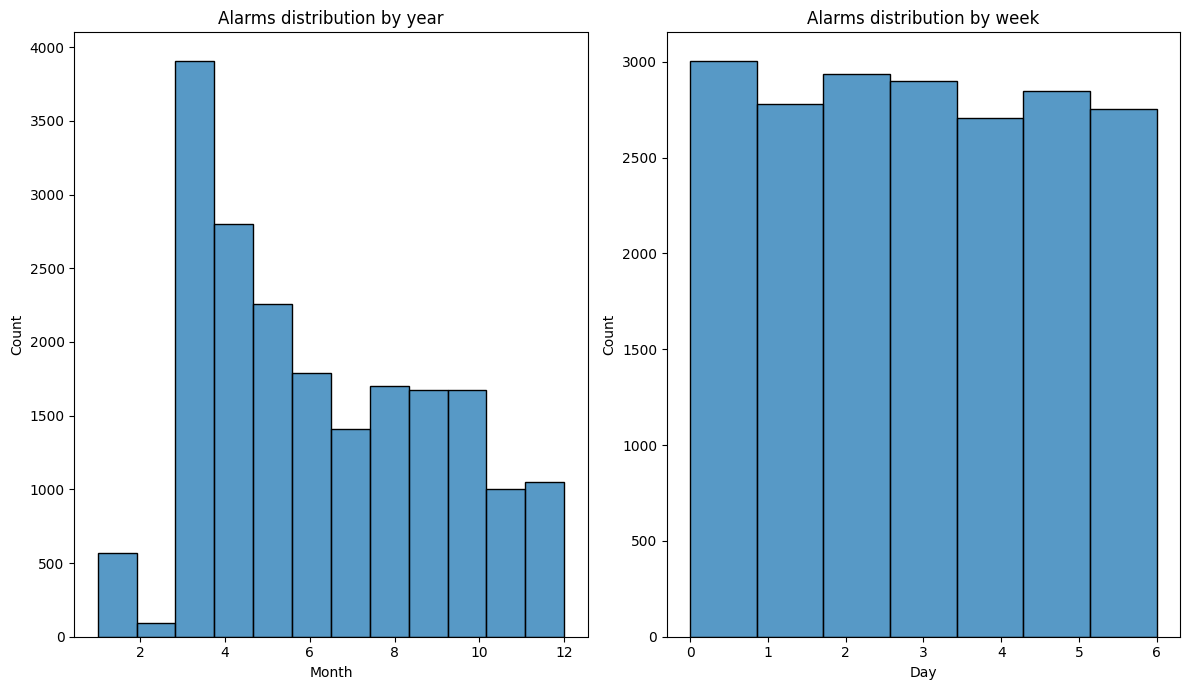

In [6]:
months = alarms["start"].dt.month
days = alarms["start"].dt.dayofweek


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

sns.histplot(data=months, bins=12, ax=ax1).set(xlabel="Month", title="Alarms distribution by year")
sns.histplot(data=days, bins=7, ax=ax2).set(xlabel="Day", title="Alarms distribution by week")
# ax1.hist(months, bins = range(1, 13, 1))
# ax1.set_title("Alarms distribution by months")

# ax2.hist(days, bins = range(1, 32, 1))
# ax2.set_title("Alarms distribution by day")
fig.tight_layout()

According to plots, there is no correlation between days of week and number of alarms. However, we can see that there is low number of alarms in Ferbuary, and high number in March. We can make an assumption, that high number of alarms in March may be due to the fact that March is the first month of the war with a large intensification of hostilities. On the other hand, low number in February leads to [low number of data](#low_num_of_data) from this month.

### Alarms distribution by regions <a class="anchor" id="alarms_in_regions"></a>

/tmp/ipykernel_15750/2610327070.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(regions.unique(), minor=False, rotation=60)


[Text(0, 0, 'Вінниччина'),
 Text(1, 0, 'Львівщина'),
 Text(2, 0, 'Одещина'),
 Text(3, 0, 'Житомирщина'),
 Text(4, 0, 'Рівненщина'),
 Text(5, 0, 'Волинь'),
 Text(6, 0, 'Хмельниччина'),
 Text(7, 0, 'Тернопільщина'),
 Text(8, 0, 'Запоріжжя'),
 Text(9, 0, '️Донеччина'),
 Text(10, 0, 'Дніпропетровщина'),
 Text(11, 0, 'Кіровоградщина'),
 Text(12, 0, 'Київщина'),
 Text(13, 0, 'Чернігівщина'),
 Text(14, 0, 'Черкащина'),
 Text(15, 0, 'Полтавщина'),
 Text(16, 0, 'Миколаївщина'),
 Text(17, 0, 'Буковина'),
 Text(18, 0, 'Івано-Франківщина'),
 Text(19, 0, 'Харківщина'),
 Text(20, 0, 'Сумщина'),
 Text(21, 0, 'Закарпаття'),
 Text(22, 0, 'Херсонщина')]

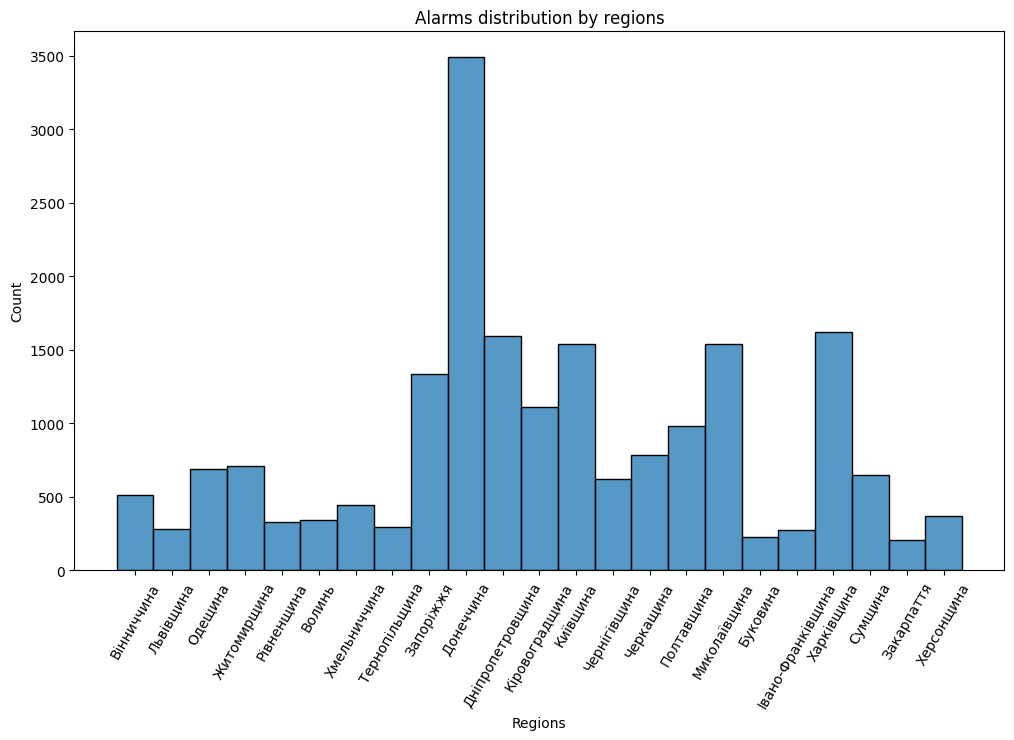

In [7]:
regions = alarms["region_title"]

fig, ax = plt.subplots(figsize=(12, 7))

plot = sns.histplot(data=regions, bins=len(regions))
plot.set_title("Alarms distribution by regions")
plot.set_xlabel("Regions")
plot.set_xticklabels(regions.unique(), minor=False, rotation=60)

Most number of alarms was detected in Donetsk, as expected.

### Alarms distribution by duration <a class="anchor" id="alarms_durations"></a>

[Text(0, 0.5, 'Duration in minutes'),
 Text(0.5, 1.0, 'Alarms distribution by Durations')]

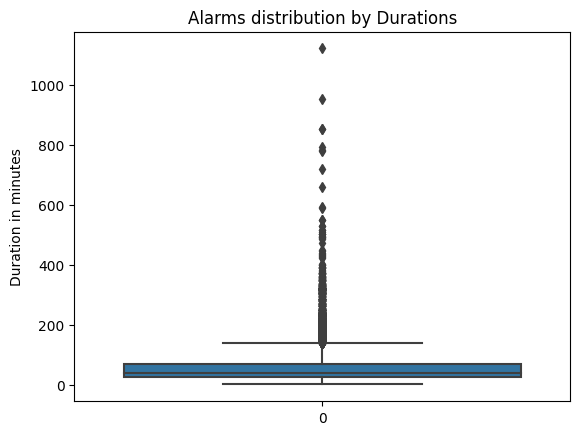

In [8]:
sns.boxplot(data=alarms["duration"].dt.total_seconds()/60).set(ylabel="Duration in minutes", title="Alarms distribution by Durations")

We can see that most frequently alarm duration less than 200 minutes; however, there are a lot of outliners above 200 minutes.

## Analyze weather data <a class="anchor" id="weather"></a>

## Analyze ISW reports <a class="anchor" id="reports"></a>

### The time interval that the data cover <a class="anchor" id="reports_time"></a>

In [9]:
reports["date"] = pd.to_datetime(reports["date"])
print(f"First report: {min(reports['date']).date()}")
print(f"Last report: {max(reports['date']).date()}")

First report: 2022-02-25
Last report: 2023-01-25


We can see that isw reports don't cover Ferbuary, so we have low number of data from this month <a class="anchor" id="low_num_of_data"></a>

In [28]:
# Some functions for preprocessing text data

def preprocess(data):
    data = remove_one_letter_word(data)
    data = remove_url_from_string(data)
    data = convert_lower_case(data)
    data = remove_punctuation(data)
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = remove_punctuation(data)
    
    return data

def stemm_text(data, word_root_algo="lemm"):   
    if word_root_algo == "lemm":
        data = lemmatizing(data)
    else:
        data = stemming(data)
        
    data = remove_punctuation(data)
    data = remove_stop_words(data)
    
    return data

### N-grams analyzis <a class="anchor" id="reports_n_grams"></a>

In [13]:
reports['content_text'] = reports['content_text'].apply(lambda x: preprocess(x))
text = ' '.join(reports["content_text"])

print(text[:10000])

 russian forces entered major ukrainian cities including kyiv kherson first time february twenty five russian forces main axes advance focused kyiv successfully isolating city banks dnipro river russian military operations along ukraine northern border less well planned organized conducted emanating crimea also less successful far divergence performance likely arises part differences composition organization russian ground forces elements western military district belarus ukraine north southern military district black sea fleet south east isw previously observed determined well organized ukrainian resistance around kyiv kharkiv also played important role preventing russian military advancing speed success reportedly planned russian military deployed additional forces southeastern belarus likely beyond moscow planned use ukraine offset problems challenges russian forces remain much larger capable ukraine conventional military however russia likely defeat ukrainian regular military force

In [16]:
tokens = nltk.word_tokenize(text)

bigrams = list(nltk.ngrams(tokens, 2))
trigrams = list(nltk.ngrams(tokens, 3))
print(bigrams[:10])
print(trigrams[:10])

[('russian', 'forces'), ('forces', 'entered'), ('entered', 'major'), ('major', 'ukrainian'), ('ukrainian', 'cities'), ('cities', 'including'), ('including', 'kyiv'), ('kyiv', 'kherson'), ('kherson', 'first'), ('first', 'time')]
[('russian', 'forces', 'entered'), ('forces', 'entered', 'major'), ('entered', 'major', 'ukrainian'), ('major', 'ukrainian', 'cities'), ('ukrainian', 'cities', 'including'), ('cities', 'including', 'kyiv'), ('including', 'kyiv', 'kherson'), ('kyiv', 'kherson', 'first'), ('kherson', 'first', 'time'), ('first', 'time', 'february')]


In [18]:
def get_most_frequent_n_grams_for_plot(n_grams: list):
    counted_n_grams = Counter(n_grams)
    counted_n_grams = dict(sorted(counted_n_grams.items(), key=lambda x:x[1], reverse=True))
    keys_n_grams = list(map(' '.join ,list(counted_n_grams.keys())[:10]))
    values_n_grams = list(counted_n_grams.values())[:10]
    return keys_n_grams, values_n_grams

[Text(0.5, 0, 'Count'),
 Text(0, 0.5, 'Trigrams'),
 Text(0.5, 1.0, 'Most frequent trigrams')]

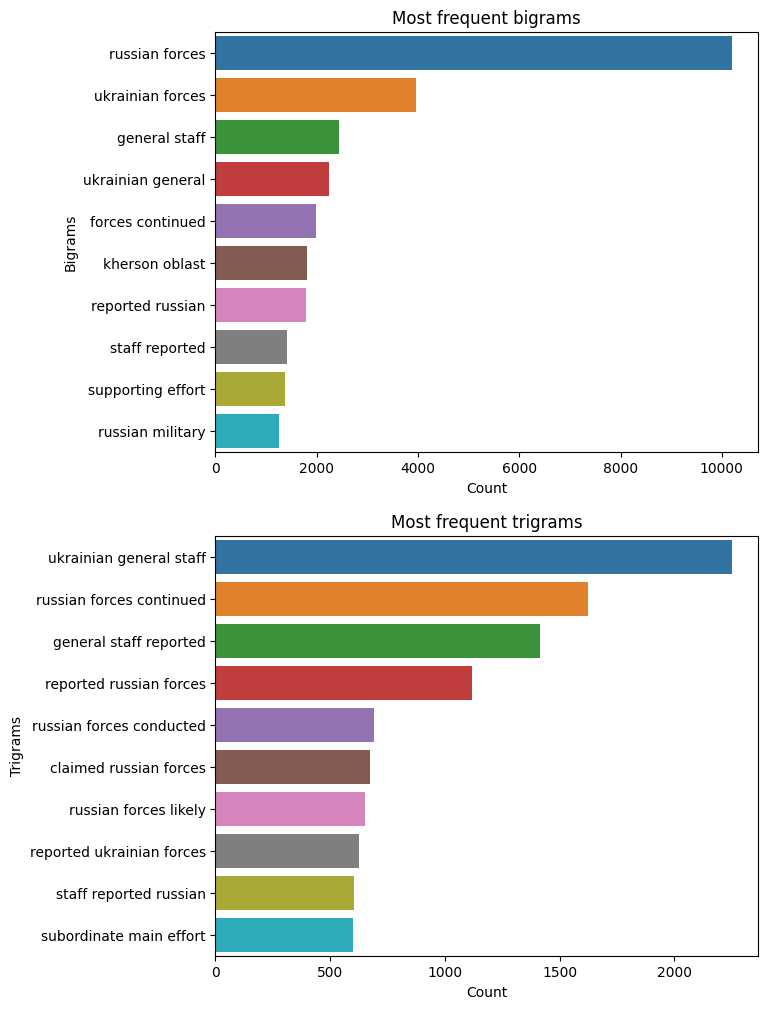

In [19]:
keys_bigrams, values_bigrams = get_most_frequent_n_grams_for_plot(bigrams)
keys_trigrams, values_trigrams = get_most_frequent_n_grams_for_plot(trigrams)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 12))


sns.barplot(
    x = values_bigrams,
    y = keys_bigrams,
    orient='h',
    ax=ax1).set(xlabel="Count", ylabel="Bigrams", title="Most frequent bigrams")

sns.barplot(
    x = values_trigrams,
    y = keys_trigrams,
    orient='h',
    ax=ax2).set(xlabel="Count", ylabel="Trigrams", title="Most frequent trigrams")

### Idf-weights <a class="anchor" id="reports_idf"></a>

In [32]:
reports['content_text_lemm'] = reports['content_text'].apply(lambda x: stemm_text(x, "lemm"))
docs = reports['content_text_lemm'].tolist()

In [35]:
cv = pd.read_pickle(os.path.join(pathlib.Path().resolve(), 'data/isw/count_vectorizer_v1.pkl'))
word_count_vector = cv.fit_transform(docs)

word_count_vector.shape

(332, 8942)

In [37]:
tridf_transformer = pd.read_pickle(os.path.join(pathlib.Path().resolve(), 'data/isw/tfidf_transformer_v1.pkl'))
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [38]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(), columns=["idf_weights"])

df_idf.sort_values(by=["idf_weights"])

,idf_weights
attack,1.021245
war,1.021245
luhansk,1.021245
position,1.024317
combat,1.024317
...,...
skeptical,5.709530
inefficiency,5.709530
inefficient,5.709530
incoherence,5.709530


[Text(0.5, 0, 'idf_weighst'),
 Text(0, 0.5, 'Words'),
 (1.0, 1.05),
 Text(0.5, 1.0, 'Words with lowest idf weights')]

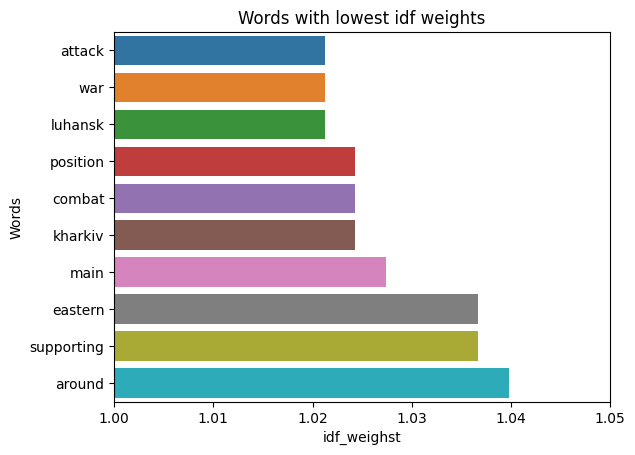

In [57]:
words = df_idf.sort_values(by=["idf_weights"]).index[:10]
idf_weights = list(map(float, df_idf.sort_values(by=["idf_weights"]).values[:10]))

sns.barplot(
    x = idf_weights,
    y = words,
    orient='h').set(xlabel="idf_weighst", ylabel="Words", xlim=(1, 1.05), title="Words with lowest idf weights")


<a class="anchor" id="low_num_of_data"></a>